In [1]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import time, os
from datetime import datetime
import crcmod

In [3]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[1].device
    port_motor = ports[0].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM7
Порт 1: COM3
Для получения данных выбран порт - COM3
Для двигателя выбран порт - COM7


In [ ]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    distance = 115*15
    speed=100
    command = f'ON\rMOVE L(-{int(distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

In [ ]:
BAUDRATE = 2000000
# BAUDSPEED = 300000 max
BAUDSPEED = 100000
# N_SAMPLES = 4194304 max
N_SAMPLES = 400000

In [24]:
# Чтение данных с катушек в память контроллера
with (serial.Serial(port, baudrate=BAUDRATE, bytesize=8, stopbits=1, timeout=None)) as serialData:
    # Read data from Sensor
    command = f'R{BAUDSPEED};{N_SAMPLES}\n'
    # Send the command to the DataPort
    # serialData.write(command.encode(encoding="utf-8"))
    serialData.write(command.encode())
    dataRead = serialData.readline()
    dataReady = serialData.readline()

print(f'{dataRead}')
print(f'{dataReady}')  

b'F=100 kSPS,N=250000\n'
b'1\n'


In [25]:
TIMEBASE_CONSTANT = int(float(dataRead.decode().split('F=')[1].split()[0].replace(',','.'))*1000)  # Постоянная времени системы [мкс]
TIMEBASE_CONSTANT

100000

In [26]:
N_SAMPLES_STEP = 1000
ADC = b''
EDC = b''

# Создаём объект CRC-16-CCITT-ZERO
crc16_func = crcmod.mkCrcFun(
    poly=0x11021,      # Полином: x^16 + x^12 + x^5 + 1 (0x1021, но с битом переноса)
    initCrc=0x0000,  # Начальное значение — 0x0000 (ZERO)
    xorOut=0x0000,   # Окончательный XOR — 0x0000
    rev=False          # Прямой порядок битов (normal)
)

# Чтение данных из памяти контроллера
with (serial.Serial(port, baudrate=BAUDRATE, bytesize=8, stopbits=1, timeout=1)) as serialData:
    for i in range(0, int(N_SAMPLES), N_SAMPLES_STEP):

        command = f'S{i};{N_SAMPLES_STEP}\n'
        serialData.write(command.encode())

        lineADC = serialData.read(2*N_SAMPLES_STEP+9)
        dataADC = lineADC[6:-3]
        crcADC = lineADC[-3:-1]
        if crc16_func(dataADC) != int.from_bytes(crcADC, 'big'):
            print('DataADC not ok')
        else:
            ADC += dataADC

        lineEDC = serialData.read(2*N_SAMPLES_STEP+9)
        dataEDC = lineEDC[6:-3]
        crcEDC = lineEDC[-3:-1]
        if crc16_func(dataEDC) != int.from_bytes(crcEDC, 'big'):
            print('DataEDC not ok')
        else:
            EDC += dataEDC

In [27]:
rawADC = np.frombuffer(ADC, dtype=np.uint8)
data = rawADC.view(dtype='>i2').astype(np.int16)
rawEDC = np.frombuffer(EDC, dtype=np.uint8)
encoder = rawEDC.view(dtype='>i2').astype(np.int16)

df_raw = pd.DataFrame({
    'encoder': encoder,
    'data': data
})

# Фильтрация данных от дельта-шумов
window_size = 3
trim_offset = window_size // 2

# Применяем фильтр и обрезаем сразу для обоих столбцов
# Создаем новый DataFrame с отфильтрованными данными
df_filtered = pd.DataFrame({
    'encoder': signal.medfilt(encoder, kernel_size=window_size)[trim_offset:-trim_offset],
    'data': signal.medfilt(data, kernel_size=window_size)[trim_offset:-trim_offset]    
})

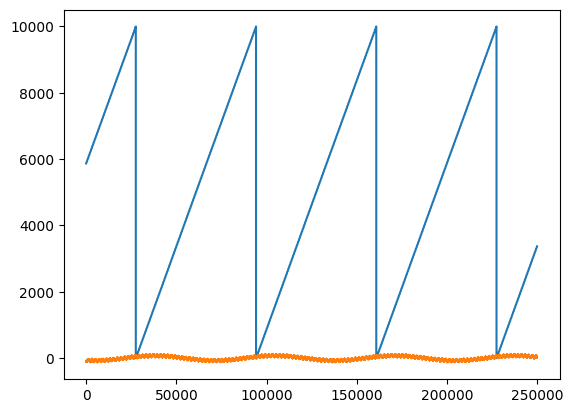

In [28]:
plt.plot(df_filtered)

In [ ]:
if 0:
    df_raw = pd.read_csv(os.path.join('data','data_raw_2025-12-19_16-07-44 1142 -85.csv'), index_col=0, skiprows=4)

    # Фильтрация данных от дельта-шумов
    df_filtered = pd.DataFrame()
    window_size = 3
    trim_offset = window_size // 2

    # Применяем фильтр и обрезаем сразу для обоих столбцов
    # Создаем новый DataFrame с отфильтрованными данными
    df_filtered['data'] = signal.medfilt(df_raw.data, kernel_size=window_size)[trim_offset:-trim_offset]
    df_filtered['encoder'] = signal.medfilt(df_raw.encoder, kernel_size=window_size)[trim_offset:-trim_offset]


In [29]:
# Отрезаем целое число периодов

# индексы, где энкодер "прыгнул"
diff_enc = df_filtered['encoder'].shift(1) - df_filtered['encoder']
split_points = df_filtered.index[diff_enc.abs() > 1000]  # по модулю, чтобы не зависить от направления (?)

print(f'Найдено {len(split_points)-1} периодов энкодера')

if len(split_points) in (0, 1):
    print("Warning: Нет переходов нуля энкодера.")
    df_trimmed = df_filtered.copy()
else:
    start_idx = split_points[0]
    end_idx = split_points[-1]
    # Проверка, чтобы start_idx был меньше end_idx
    if start_idx >= end_idx:
        print(f"Warning: start_idx ({start_idx}) >= end_idx ({end_idx}). Returning original DataFrame.")
        df_trimmed = df_filtered.copy()
    else:
        df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

Найдено 3 периодов энкодера


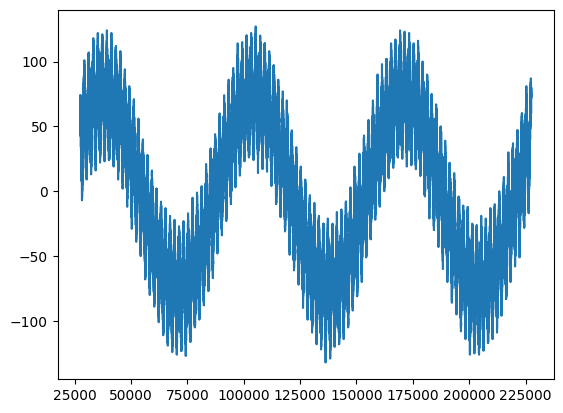

In [30]:
plt.plot(df_trimmed.data)

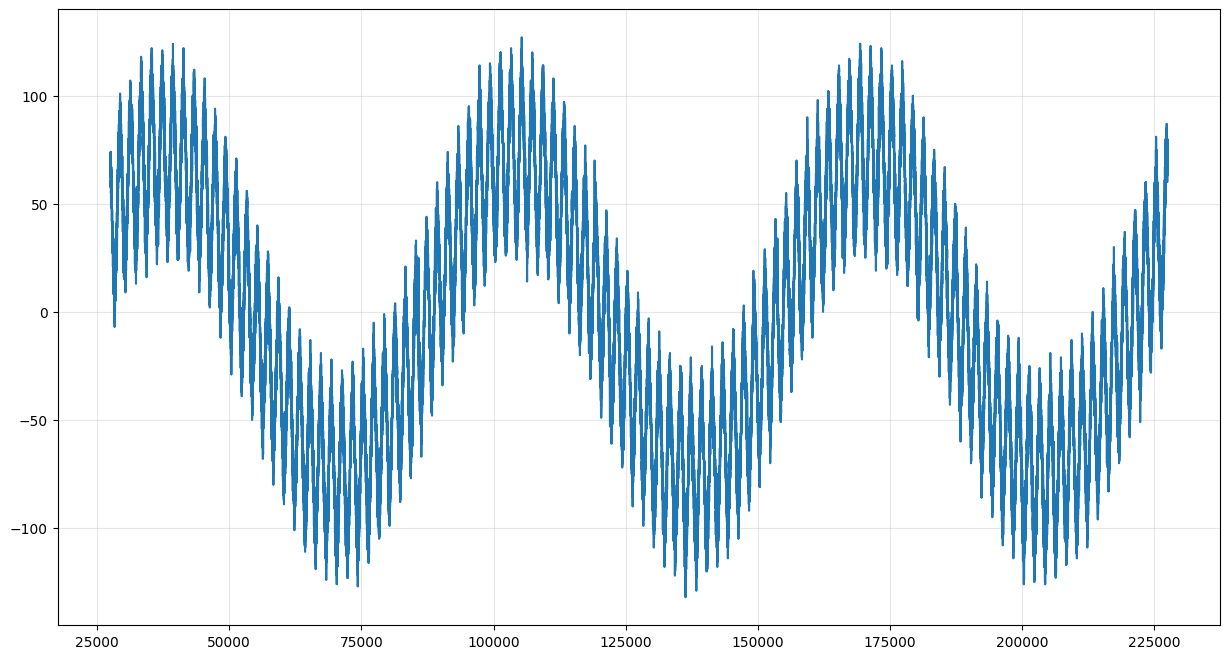

In [31]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.grid(True, alpha=0.3) # Улучшаем сетку
plt.plot(df_trimmed.data)
# plt.plot(df_filtered.data)
# plt.plot(df_raw.data)

In [38]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
# 1. Группировка по периодам (непрерывные одинаковые значения encoder)
df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

# 2. Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'first', 'period': 'first'}).reset_index(drop=True)

# 3. Интеграл (кумулятивная сумма)
df_res['integral'] = -1.0*df_res.data.cumsum()

# from scipy import integrate
# dt = 1
# df_res['integral'] = -1.0 * integrate.cumulative_trapezoid(df_res['data'], dx=dt, initial=0)

# 4. Пересчет в Вольты*метры*секунды
#  2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
# df_res['volts'] = signal.detrend((2.5/32767 * 1/96937 * 1/1144.8)*df_res['integral'], type='linear')
df_res['volts'] = (2.5/32767 * 1/TIMEBASE_CONSTANT * 1/1144.8)*df_res['integral']

# 5. Детренд

x = df_res.index.values
y = df_res.volts.values

# Координаты первой и последней точек
x0, x1 = x[0], x[-1]
y0, y1 = y[0], y[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем трендовую составляющую и вычитаем
y_trend = a * x + b
df_res['detrend'] = y - y_trend

# 5. Угол в градусах
df_res['deg'] = (df_res['period']/10000)*360

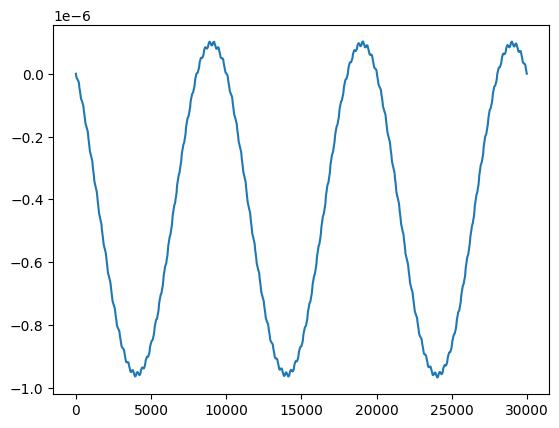

In [39]:
plt.plot(df_res.detrend)

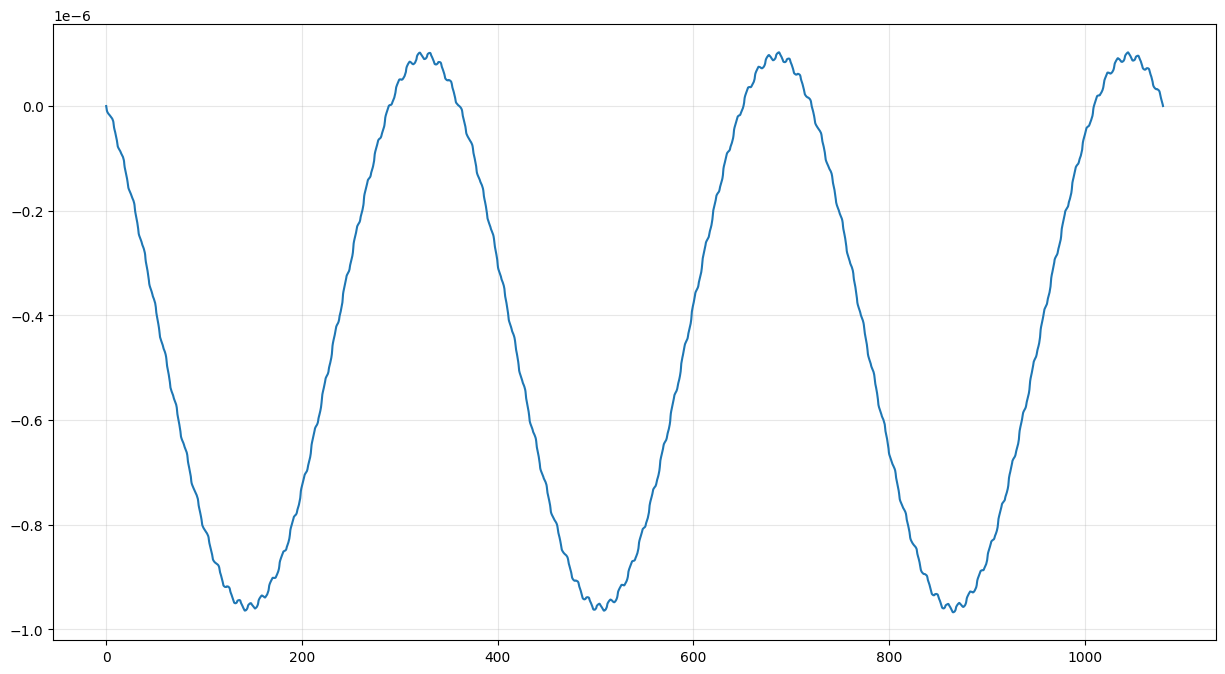

In [40]:
%matplotlib inline
# df_res = pd.read_csv(os.path.join('data','data_res.csv'), index_col=None)
# plt.plot(df_res.volts)
plt.figure(figsize=(15, 8))
plt.grid(True, alpha=0.3) # Улучшаем сетку
plt.plot(df_res.deg, df_res.detrend)
# plt.tight_layout()
plt.show()

In [41]:
# FastGoertzel

import fastgoertzel as fg

PT = 10000

amp_fg, phase_fg = fg.goertzel(df_res.detrend.values, 1/PT)
phase_fgd = (phase_fg+np.pi/2)*180/np.pi

# df_res['fastgoertzel'] = amp_fg * np.cos(2*np.pi * 1/PT * df_res.index.values + phase_fg)

print(f'FastGoertzel Amp: {amp_fg:.6e}, {phase_fgd = :.3f}°')

FastGoertzel Amp: 5.275264e-07, phase_fgd = 125.007°


In [35]:
# --- Данные ---
theta_deg = df_res['deg'].values          # угол в градусах
x = df_res['detrend'].values              # исходный сигнал (без DC)
f_amp = amp_fg                               # амплитуда от Goertzel (пиковое значение!)
f_phase_deg = phase_fgd                         # фаза от Goertzel, в градусах

# --- Восстановление основной гармоники ---
# Важно: метод Гёрцеля обычно даёт фазу для косинуса вида A*cos(ωn + φ)
# где ω = 2πk/N, но в угловой шкале ω соответствует 1 циклу на 360°
x_fund = f_amp * np.sin(np.deg2rad(theta_deg + f_phase_deg))

# Альтернативная запись (эквивалентна):
# x_fund = f_amp * np.cos(np.deg2rad(theta_deg) + np.deg2rad(f_phase_deg))

# --- Остаток ---
residual = x - x_fund

# --- Метрики различия ---

# RMSE
rmse = np.sqrt(np.mean(residual**2))

# RMS значений
rms_total = np.sqrt(np.mean(x**2))
rms_fund = np.sqrt(np.mean(x_fund**2))  # ≈ f_amp / sqrt(2), если покрыто целое число периодов

# THD (Total Harmonic Distortion)
if rms_fund > 1e-12:
    thd = np.sqrt(max(rms_total**2 - rms_fund**2, 0.0)) / rms_fund
else:
    thd = np.inf

# SNR (в дБ)
noise_power = np.mean(residual**2)
if noise_power > 1e-12:
    snr_db = 10 * np.log10(rms_fund**2 / noise_power)
else:
    snr_db = np.inf

# --- Вывод результатов ---
print(f"RMSE между сигналом и 1× гармоникой: {rmse:.6e}")
print(f"THD:  {thd:.6f}  ({100 * thd:.3f} %)")
print(f"SNR:  {snr_db:.2f} dB")

RMSE между сигналом и 1× гармоникой: 2.098910e-07
THD:  0.005734  (0.573 %)
SNR:  inf dB


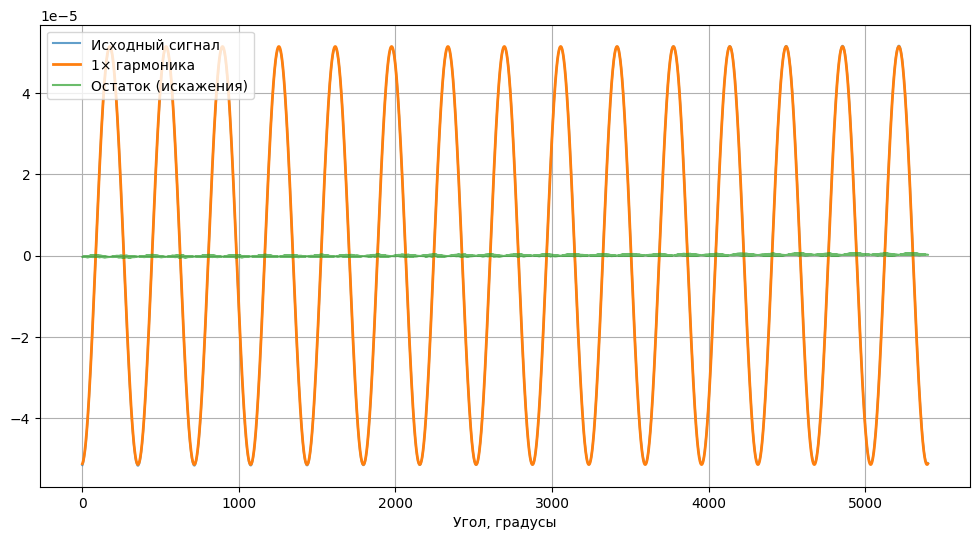

In [37]:
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(theta_deg, x, label='Исходный сигнал', alpha=0.7)
plt.plot(theta_deg, x_fund, label='1× гармоника', linewidth=2)
plt.plot(theta_deg, residual, label='Остаток (искажения)', alpha=0.7)
plt.xlabel('Угол, градусы')
plt.legend()
plt.grid(True)
plt.show()

Скорость 200: FastGoertzel Amp: 1.672600e-10, phase_fgd = 163.897°
Скорость 100: FastGoertzel Amp: 6.938956e-07, phase_fgd = 11.041°
Скорость 50:  FastGoertzel Amp: 6.985378e-07, phase_fgd = 11.128°

In [66]:
# Запись данных в файл
try:
    os.mkdir('data')
except FileExistsError:
    pass
except Exception as e:
    print(f'Что-то пошло не так: {e}')

filename = f"data_res_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
dir = 'data'

df_res.to_csv(os.path.join(dir, filename))

In [30]:
# FastGoertzel

import fastgoertzel as fg

PT = 10000

amp_fg, phase_fg = fg.goertzel(df_res.detrend.values, 1/PT)
phase_fgd = (phase_fg+np.pi/2)*180/np.pi

# df_res['fastgoertzel'] = amp_fg * np.cos(2*np.pi * 1/PT * df_res.index.values + phase_fg)

print(f'FastGoertzel Amp: {amp_fg:.6e}, {phase_fgd = :.3f}°')

FastGoertzel Amp: 3.098380e-10, phase_fgd = 240.931°


In [ ]:
def calculate_thd(Fourier_series):
    numerator = 0
    for i in range (2, len(Fourier_series)):
        numerator += (math.pow(np.abs(Fourier_series[i]), 2))

    thd = 100*math.sqrt(numerator)/(np.abs(Fourier_series[1]))

    return thd

# voltage - гармонический сигнал
F = sp.fft.rfft(voltage)
thd_out = calculate_thd(F)

In [31]:
# SlowGoertzel

PT = 10000 # точек на период
N = len(df_res)-len(df_res)%PT # количество отсчетов
omega = 2*np.pi/PT # угловая частота
k = int(N/PT) # номер гармоники
omega = 2*np.pi*k/N
alpha = 2*np.cos(omega)

print(f'{N=}, {PT=}, {k=}, {alpha=:}')

result = df_res.copy()

time0 = time.time()
result['s'] = 0.0
n = 0
result.loc[n, 's'] = result.loc[n, 'detrend'] + alpha*0 - 0
n = 1
result.loc[n, 's'] = result.loc[n, 'detrend'] + alpha*result.loc[n-1, 's'] - 0

for n in range(2, len(result)):
    result.loc[n, 's'] = result.loc[n, 'detrend'] + alpha*result.loc[n-1, 's'] - result.loc[n-2, 's']

time1 = time.time() - time0
print(f'{time1 = }')

# Последние два значения для вычисления амплитуды и фазы
F2 = result.loc[N-1, 's']
F3 = result.loc[N-2, 's']

# Вычисляем реальную и мнимую части
real = F2*np.cos(omega)-F3
imag = F2*np.sin(omega)

amp_sg = np.sqrt(real**2 + imag**2)*2/N 
phase_sgd = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

print(f'SlowGoertzel Amp: {amp_sg:.6e}, {phase_sgd = :.3f}°')

# было 1m 31 s
# было 1m 3  s
# было 49,8 s
# было 26.4 s

N=300000, PT=10000, k=30, alpha=1.9999996052158369
time1 = 44.10952138900757
SlowGoertzel Amp: 6.787049e-07, phase_sgd = 11.006°


In [36]:
# Faster Goertzel lfilter
from scipy import signal

# Параметры
PT = 10000  # точек на период
N = len(df_res) - len(df_res) % PT  # количество отсчётов
k = int(N / PT)  # номер гармоники
omega = 2 * np.pi * k / N
alpha = 2 * np.cos(omega)

print(f'{N=}, {PT=}, {k=}, {alpha=: .6f}')

# Выбираем нужный столбец сигнала
signal_data = df_res['detrend'].values  # Обрезаем до длины N

# Коэффициенты фильтра для алгоритма Goertzel
b = [1]  # числитель
a = [1, -alpha, 1]  # знаменатель

# Применяем фильтр
filtered = signal.lfilter(b, a, signal_data)

# Последние два значения для вычисления амплитуды и фазы
F2 = filtered[-1]
F3 = filtered[-2]

# Вычисляем реальную и мнимую части
real = F2*np.cos(omega)-F3
imag = F2*np.sin(omega)

# Амплитуда и фаза
amp_fg2 = np.sqrt(real**2 + imag**2) * 2 / N
phase_fgd2 = (np.arctan2(imag, real) + np.pi / 2) * 180 / np.pi

print(f'FasterGoertzel Amp: {amp_fg2 = :.6e}, {phase_fgd2 = :.3f}°')

N=300000, PT=10000, k=30, alpha= 2.000000
FasterGoertzel Amp: amp_fg2 = 7.017258e-07, phase_fgd2 = 10.778°


In [37]:
# Faster Goertzel sosfilter

# Параметры
PT = 10000  # точек на период
N = len(df_res) - len(df_res) % PT  # количество отсчётов
k = int(N / PT)  # номер гармоники
omega = 2 * np.pi * k / N
alpha = 2 * np.cos(omega)

print(f'{N=}, {PT=}, {k=}, {alpha=: .6f}')

# Выбираем нужный столбец сигнала
signal_data = df_res['detrend'].values  # Обрезаем до длины N

# Создаём коэффициенты в формате SOS (Second Order Sections)
# b = [1], a = [1, -alpha, 1]
sos = signal.tf2sos([1], [1, -alpha, 1])

# Применяем фильтр
filtered = signal.sosfilt(sos, signal_data)

# Последние два значения для вычисления амплитуды и фазы
F2 = filtered[-1]
F3 = filtered[-2]

# Вычисляем реальную и мнимую части
real = F2*np.cos(omega)-F3
imag = F2*np.sin(omega)

# Амплитуда и фаза
amp_sosg = np.sqrt(real**2 + imag**2) * 2 / N
phase_sosgd = (np.arctan2(imag, real) + np.pi / 2) * 180 / np.pi

print(f'SOSGoertzel Amp: {amp_sosg:.6e}, {phase_sosgd = :.3f}°')

N=300000, PT=10000, k=30, alpha= 2.000000
SOSGoertzel Amp: 7.017258e-07, phase_sosgd = 10.778°


In [69]:
print(f'FastGoertzel Amp:   {amp_fg:.6e}, {phase_fgd:.3f}°')
print(f'SlowGoertzel Amp:   {amp_sg:.6e}, {phase_sgd:.3f}°')
print(f'FasterGoertzel Amp: {amp_fg2:.6e}, {phase_fgd2:.3f}°')
print(f'SOSGoertzel Amp:    {amp_sosg:.6e}, {phase_sosgd:.3f}°')

FastGoertzel Amp:   5.147222e-05, -84.667°
SlowGoertzel Amp:   5.147222e-05, -84.667°
FasterGoertzel Amp: 5.147222e-05, -84.667°
SOSGoertzel Amp:    5.147222e-05, -84.667°


In [61]:
print(f'FastGoertzel Amp:   {amp_fg:.6e}, {phase_fgd:.3f}°')
print(f'SlowGoertzel Amp:   {amp_sg:.6e}, {phase_sgd:.3f}°')
print(f'FasterGoertzel Amp: {amp_fg2:.6e}, {phase_fgd2:.3f}°')
print(f'SOSGoertzel Amp:    {amp_sosg:.6e}, {phase_sosgd:.3f}°')

FastGoertzel Amp:   5.147419e-05, -84.668°
SlowGoertzel Amp:   5.147419e-05, -84.668°
FasterGoertzel Amp: 5.147419e-05, -84.668°
SOSGoertzel Amp:    5.147419e-05, -84.668°


In [52]:
print(f'FastGoertzel Amp:   {amp_fg:.6e}, {phase_fgd:.3f}°')
print(f'SlowGoertzel Amp:   {amp_sg:.6e}, {phase_sgd:.3f}°')
print(f'FasterGoertzel Amp: {amp_fg2:.6e}, {phase_fgd2:.3f}°')
print(f'SOSGoertzel Amp:    {amp_sosg:.6e}, {phase_sosgd:.3f}°')

FastGoertzel Amp:   5.147487e-05, -84.677°
SlowGoertzel Amp:   5.147487e-05, -84.677°
FasterGoertzel Amp: 5.147487e-05, -84.677°
SOSGoertzel Amp:    5.147487e-05, -84.677°


In [ ]:
# Детрендирование и поиск экстремумов
x_tr = df_res.index
y_tr = df_res.volts.values

# Координаты первой и последней точек
x0, x1 = x_tr[0], x_tr[-1]
y0, y1 = y_tr[0], y_tr[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем тренд
df_res['trend'] = a * x_tr + b

# Детрендированные данные
df_res['detrended1'] = (df_res.volts - df_res.trend)
df_res['detrended2'] = signal.detrend(df_res.volts, type='linear')


# df = df_res.copy()
# # Локальные максимумы
# local_maxima = signal.argrelextrema(df.detrended.values, np.greater, order=100)[0]
# # Локальные минимумы
# local_minima = signal.argrelextrema(df.detrended.values, np.less, order=100)[0]

# print(f"Найдено локальных максимумов: {len(local_maxima)}")
# print(f"Найдено локальных минимумов: {len(local_minima)}")

# # Добавляем метки в DataFrame
# df['is_local_max'] = False
# df['is_local_min'] = False

# df.loc[local_maxima, 'is_local_max'] = True
# df.loc[local_minima, 'is_local_min'] = True

# data = 'detrended'

# # Извлечение экстремумов
# maxima = df[df['is_local_max']]
# minima = df[df['is_local_min']]

# # Вычисляем средние значения
# mean_max = maxima[data].mean()
# mean_min = minima[data].mean()

# # Разность средних
# amp_peak = (mean_max - mean_min)/2

# # 3. Вычисляем погрешности
# # Погрешность среднего значения максимумов
# std_max = maxima[data].std(ddof=1)
# std_error_max = std_max / np.sqrt(len(maxima))

# # Погрешность среднего значения минимумов
# std_min = minima[data].std(ddof=1)
# std_error_min = std_min / np.sqrt(len(minima))

# # Абсолютная погрешность амплитуды (по формуле погрешности разности)
# absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# # Относительная погрешность амплитуды
# relative_error = absolute_error / amp_peak * 100  # в процентах

# # print(f"   Амплитуда = {amp_peak:.6} ± {absolute_error:.2}")
# # print(f"   Относительная погрешность: {relative_error:.4f}%")
# print(f'Peak Amp: {amp_peak:.6e}')

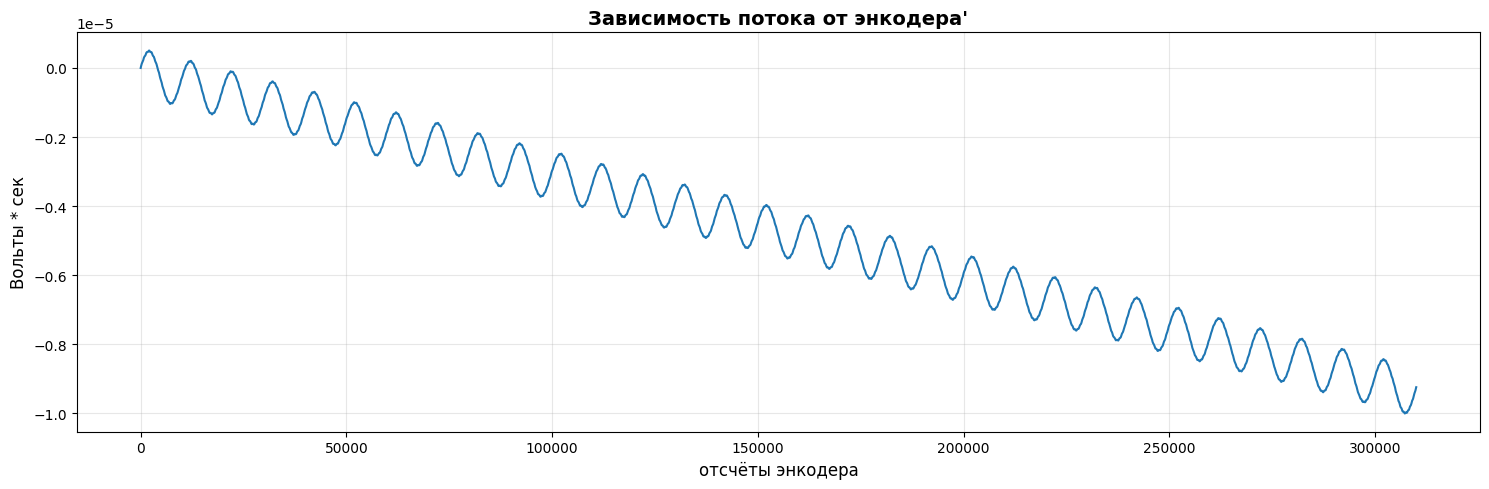

In [43]:
%matplotlib inline
# Создаем график с настройками
plt.figure(figsize=(15, 5))
# Добавляем заголовок и подписи осей
plt.title("Зависимость потока от энкодера'", fontsize=14, fontweight='bold')
plt.xlabel("отсчёты энкодера", fontsize=12)
plt.ylabel("Вольты * сек", fontsize=12)

plt.grid(True, alpha=0.3) # Улучшаем сетку

# plt.plot(df_res.detrended1)
# plt.plot(df_res.detrended2)
plt.plot(df_res.volts)
# plt.plot(df_res.goertzel-amp_fg)

# Показываем график
plt.tight_layout()
plt.show()

In [44]:
# Если частота основной гармоники известна (например, f0)
# Предположим, что f0 — это нормированная частота (например, 1/10000, как в вашем примере с goertzel), или вы знаете fs и f0.

# import numpy as np

# Пример: f0 — нормированная частота (f_target / fs)
f0_norm = 1 / 10000  # как в вашем случае
N = len(df_res.volts.values)
n = np.arange(N)

# Вычисляем комплексный коэффициент Фурье
# exp(-j*2*pi*f*n) — базисная функция для частоты f
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * f0_norm * n))

amplitude = abs(C)
phase_rad = np.angle(C)+np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (rad): {phase_rad:.3f}')
print(f'Phase (deg): {phase_deg:.3f}°')

Amplitude: 7.72868e-07
Phase (rad): 0.169
Phase (deg): 9.676°


In [45]:
# Если частота неизвестна, и нужно найти основную гармонику
# Выполнить FFT и найти пик:

# import numpy as np

signal = df_res.volts.values
N = len(signal)
fft_vals = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/96937)  # d=1, если шаг по времени = 1, иначе d=dt

# Находим амплитуду и фазу для частоты с максимальной амплитудой (основная гармоника)
# Ищем только положительные частоты
positive_freqs = freqs[:N//2]
fft_vals_half = fft_vals[:N//2]

# Индекс максимальной амплитуды
max_idx = np.argmax(np.abs(fft_vals_half))

amplitude = 2 * abs(fft_vals_half[max_idx]) / N  # 2/N для амплитуды синусоиды
phase_rad = np.angle(fft_vals_half[max_idx]) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

freq_main = positive_freqs[max_idx]  # частота основной гармоники

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 0.0
Amplitude: 9.49060e-06
Phase (deg): 270.000°


In [46]:
# 3: Использовать scipy.signal.periodogram или welch
# Если вы хотите оценить спектр и найти пик, scipy предоставляет удобные функции:

from scipy.signal import periodogram
# import numpy as np

fs = 10000  # например, частота дискретизации (или используйте 1, если нормирована)
frequencies, power = periodogram(df_res.volts.values, fs=fs)

max_idx = np.argmax(power)
freq_main = frequencies[max_idx]
amplitude = np.sqrt(power[max_idx]) * 2  # приблизительная амплитуда

# Для фазы всё равно нужно вычислить комплексный коэффициент на freq_main
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * freq_main / fs * np.arange(N)))
phase_rad = np.angle(C) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 0.032258688877849245
Amplitude: 2.31355e-05
Phase (deg): 0.032°
